## Imports

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs

import random
import time

from matplotlib import cm
from scipy.stats import zscore
from scipy.stats.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.manifold import SpectralEmbedding


import umap

## Initial assumptions

In [5]:
# room dimensions in cm. (might break if changed)
width = 140
height = 140


# number of simulated place cells
n_cells = 200

# number of steps inside the environment
minutes = 10
nSteps = minutes * 600
print(str(minutes), "minutes is", str(nSteps), "time bins of 100ms")

# nSteps = 100000

# covariance matrix sigma for place cell class
sigma = np.array([[80, 0],
                  [0, 80]])

10 minutes is 6000 time bins of 100ms


## Place Cell class

In [6]:
# place cell class

class PlaceCell(object):

    def __init__(self, mu, sigma):

        self.mu = mu
        self.sigma = sigma
        
    def gaussian(self, x):

        xm = x - self.mu
        sigma = self.sigma
        
        factor1 = 4            # peak firing rate
        factor2 = (np.exp((-1/2) * xm.T @ np.linalg.inv(sigma) @ xm))
        result = factor1 * factor2
        
        return result
        
    def activity(self, x):
        activity = np.random.poisson(self.gaussian(x))

        return activity

## Generating and plotting place cells

### Generating place cells list

In [7]:
def generatePlaceCells(n_cells, sigma= sigma, height= height, width= width):

    cellsList = []
    for i in range(n_cells):
        # mu being location at which the cell is most active 
        mu = np.array([[random.uniform(0,width)],       # width
                       [random.uniform(0,height)]])     # height
        
        cellsList.append(PlaceCell(mu, sigma))
        
    return cellsList

In [8]:
# generating cells list

cellsList = generatePlaceCells(n_cells, sigma, height, width)


### Place field plot function

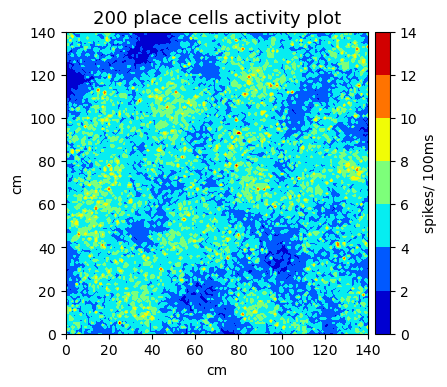

In [9]:
def plotCells(cellsList= cellsList, height = height, width = width):
    # be mindful of x and y indicies

    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)
    xLen, yLen = len(x_coordinates), len(y_coordinates)

    X, Y = np.meshgrid(x_coordinates, y_coordinates, indexing = 'xy')
    Z = np.zeros((yLen, xLen))

    for y in range(yLen):
        for x in range(xLen):
            location = np.array([[x_coordinates[x]],                    # important to be careful about the indexing
                                 [y_coordinates[y]]])
            
            for placeCell in cellsList:
                locationActivity = placeCell.activity(location)

                if Z[y][x] < locationActivity:
                    Z[y][x] = locationActivity

    plt.figure(dpi=100)
    plt.clf()
    plt.contourf(X, Y, Z, cmap = 'jet')
    plt.colorbar(label = 'spikes/ 100ms', pad = -0.17)
    plt.title(str(len(cellsList)) + " place cells activity plot", size = 13)
    plt.xlabel("cm")
    plt.ylabel("cm")
    plt.axis('square')
    plt.show()
    pass

plotCells()

## Color mapping

In [10]:
def colormapLocation(coordinates, height = height, width = width):

    normalizeX = clrs.Normalize(vmin = 0, vmax = width)
    normalizeY = clrs.Normalize(vmin = 0, vmax = height)
    normX, normY = normalizeX(coordinates[0,:]), normalizeY(coordinates[1,:])

    # mapX = cm.get_cmap('Blues')
    # mapY = cm.get_cmap('Reds')
    mapX = cm.get_cmap('binary')
    mapY = cm.get_cmap('spring')

    colorValues_X = mapX(normX)
    colorValues_Y = mapY(normY)
    colorValues = (colorValues_X + colorValues_Y)/2

    return colorValues

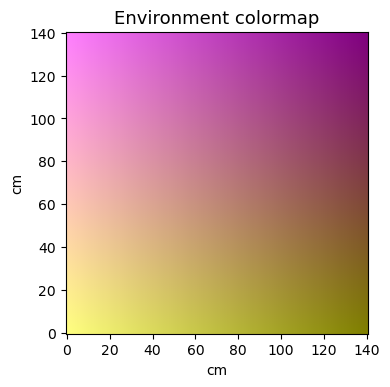

In [11]:
def plotColormapEnvironment(height = height, width = width):

    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)
    xLen, yLen = len(x_coordinates), len(y_coordinates)

    dataLocation = []
    for y in y_coordinates:
        for x in x_coordinates:
            location = np.array([[x],      #width
                                 [y]])     #height
            dataLocation.append(location)

    colormap = colormapLocation(np.hstack(dataLocation))
    environmentColorMap = colormap.reshape(yLen, xLen, 4)       ### I am very confused by the orther of the dimensions now

    plt.figure(dpi=100)
    plt.clf()
    plt.imshow(environmentColorMap)

    ## Run the code without the ticks. Then, it chooses strange numbers for x-axis. There is also a minor problem with 140 tick. There is originally 141 coordinates for both axes
    plt.xticks([0,20,40,60,80,100,120,140])
    plt.yticks([0,20,40,60,80,100,120,140], [140,120,100,80,60,40,20,0])

    plt.title("Environment colormap", size = 13)
    plt.xlabel("cm")
    plt.ylabel("cm")
    plt.show()
    pass

plotColormapEnvironment()

## Generating activity data

### Randomly teleporting mouse function (RandomMouse)

In [12]:
def randomMouse(cellsList, nSteps, height= height, width= width):

    data = []
    dataLocation = []
    for i in range(nSteps):
        location = np.array([[random.uniform(0,width)],
                             [random.uniform(0,height)]])
        # dataLocation.append(location)
        dataLocation.append(np.copy(location))

        sample = []
        for placeCell in cellsList:
            sample.append(placeCell.activity(location))
        data.append(np.hstack(np.copy(sample)))
        
    data = np.vstack(data)
    dataLocation = np.hstack(dataLocation)
        
    return (data, dataLocation)

In [13]:
(randomMouseData, randomMouseLocation) = randomMouse(cellsList, nSteps)

print("randomMouseData shape is " + str(randomMouseData.shape))
print("randomMouseLocation is " + str(randomMouseLocation.shape))

randomMouseData shape is (6000, 200)
randomMouseLocation is (2, 6000)


# Random Mouse Data Exploration

## PCA

In [14]:
randomZscore = zscore(randomMouseData)
randomZscore = np.nan_to_num(randomZscore)

randomMousePCA = PCA()
randomMousePCA.fit(randomZscore)

randomWeights = randomMousePCA.components_                                     # eigenvectors ordered by eigenvalues
randomVariance = randomMousePCA.explained_variance_                            # eigenvalues
randomExplainedVariance = np.cumsum(randomVariance)/np.sum(randomVariance)
randomPCA_scores = randomMousePCA.transform(randomZscore)                          #latent variables

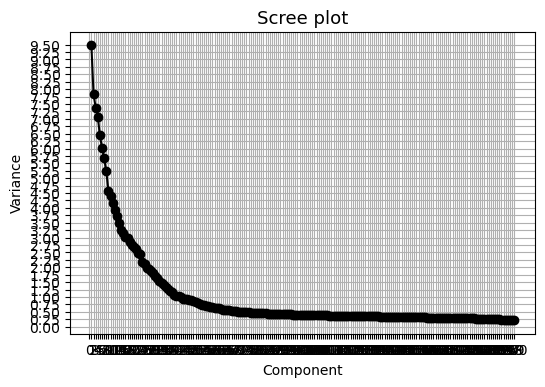

In [15]:
def plotVariance(variance):
    '''
    Plots variance (eigenvalues)
    Args:
        (numpy array of floats) : Vector of eigenvalues   ### look at the shape of the vector
    Returns:
        Nothing
    '''
    plt.figure(dpi=100, figsize=(6, 4))             # figsize=(?, 4)
    plt.clf()
    plt.plot(np.arange(1, len(variance) + 1), variance, 'o-k')

    # plt.loglog(np.arange(1, len(variance) + 1), variance, 'o-k')

    plt.title('Scree plot', size = 13)
    plt.xlabel('Component')
    plt.xticks(np.arange(0, len(variance)+1))                       ### is there a better way of doing this
    plt.ylabel('Variance')                                          ### eigenvalues
    plt.yticks(np.arange(0, max(variance)+0.25, step=0.25))
    plt.grid()
    plt.show()
    
    pass

plotVariance(randomMousePCA.explained_variance_)

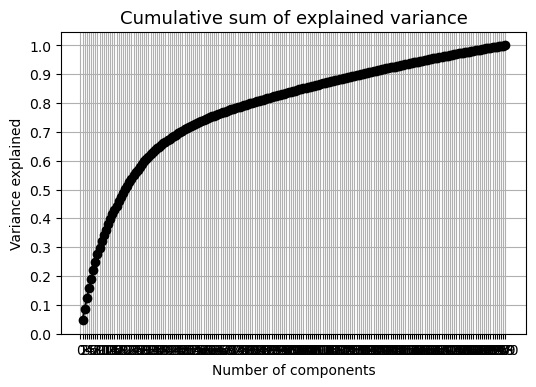

In [16]:
def plotVarianceExplained(explainedVariance):
    """
    Plots explained variance ratio
    Args:
        explainedVarianceRatio (numpy array of floats) : Vector of variance explained
                                                         for each PC
    Returns:
        Nothing.
    """
    plt.figure(dpi=100, figsize=(6, 4))
    plt.clf()
    plt.plot(np.arange(1, len(explainedVariance) + 1), explainedVariance, 'o-k')

    plt.title('Cumulative sum of explained variance', size = 13)

    plt.xlabel('Number of components')
    plt.xticks(np.arange(0, len(explainedVariance)+1))                  ### is there a better way of doing this
    plt.ylabel('Variance explained')
    plt.yticks(np.arange(0, max(explainedVariance)+0.05, step=0.1))

    plt.grid()
    plt.show()

    pass

randomExplainedVariance = np.cumsum(randomMousePCA.explained_variance_)/np.sum(randomMousePCA.explained_variance_)
plotVarianceExplained(randomExplainedVariance)

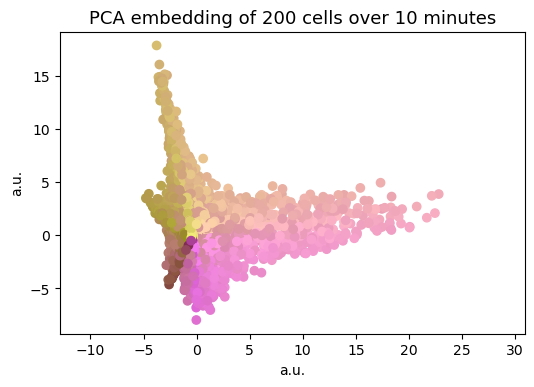

In [17]:
## plot two components

plt.figure(dpi=100)
plt.scatter(randomPCA_scores[:, 0], randomPCA_scores[:, 1], c= colormapLocation(randomMouseLocation))

plt.title(("PCA embedding of " + str(n_cells) + " cells over " + str(minutes) + " minutes"), size= 13)
plt.xlabel("a.u.")
plt.ylabel("a.u.")

plt.gca().set_aspect('equal', 'datalim')

## UMAP

In [18]:
randomReducer = umap.UMAP()     # n_neighbors=
randomUMAP_embedding = randomReducer.fit_transform(randomZscore)

print(randomUMAP_embedding.shape)

(6000, 2)


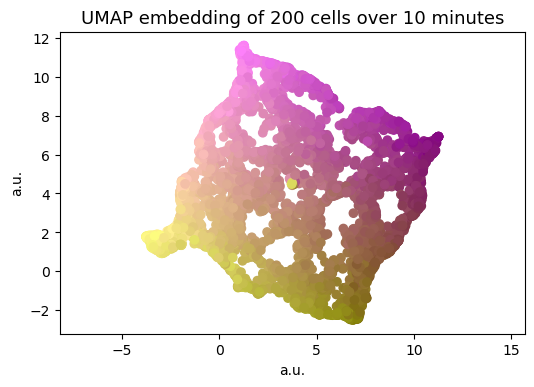

In [19]:
plt.figure(dpi=100)    # figsize=(width, height)
plt.scatter(randomUMAP_embedding[:, 0], randomUMAP_embedding[:, 1], c= colormapLocation(randomMouseLocation))

plt.title(("UMAP embedding of " + str(n_cells) + " cells over " + str(minutes) + " minutes"), size= 13)
plt.xlabel("a.u.")
plt.ylabel("a.u.")

plt.gca().set_aspect('equal', 'datalim')

In [20]:
## PCA on  master UMAP

umapZscore = zscore(randomUMAP_embedding)
umapZscore = np.nan_to_num(umapZscore)                                       ## Do I need this here?

umapMousePCA = PCA()
umapMousePCA.fit(umapZscore)

umapWeights = umapMousePCA.components_                                       # eigenvectors ordered by eigenvalues
umapVariance = umapMousePCA.explained_variance_                              # eigenvalues
umapExplainedVariance = np.cumsum(umapVariance)/np.sum(umapVariance)
umapScores = umapMousePCA.transform(umapZscore)                            # latent variables


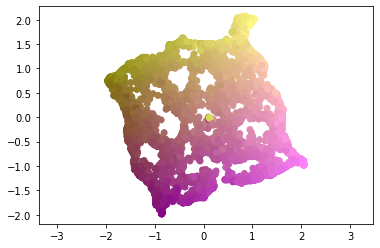

In [21]:
plt.scatter(umapScores[:, 0], umapScores[:, 1], c= colormapLocation(randomMouseLocation))
plt.gca().set_aspect('equal', 'datalim')

## Laplacian eigenmaps (spectral embedding)

In [22]:
randomLaplacian = SpectralEmbedding(n_components = 2)
randomLaplacianEmbedding = randomLaplacian.fit_transform(randomZscore)


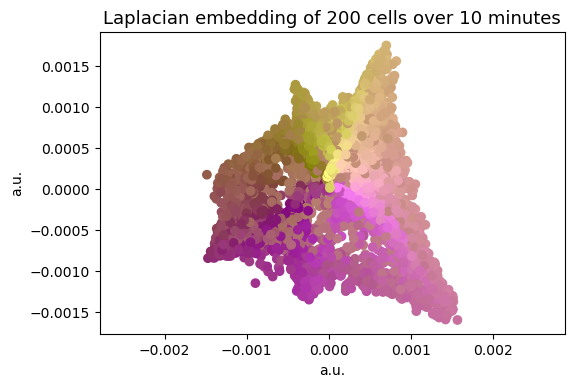

In [23]:
plt.figure(dpi=100)
plt.scatter(randomLaplacianEmbedding[:, 0], randomLaplacianEmbedding[:, 1], c= colormapLocation(randomMouseLocation))

plt.title(("Laplacian embedding of " + str(n_cells) + " cells over " + str(minutes) + " minutes"), size= 13)
plt.xlabel("a.u.")
plt.ylabel("a.u.")

plt.gca().set_aspect('equal', 'datalim')

In [24]:
# ##Save data

# Comparing distances

In [25]:
randomPCA_scores_transpose = randomPCA_scores.T[:2,:]
randomUMAP_embedding_transpose = randomUMAP_embedding.T
randomLaplacianEmbedding_transpose = randomLaplacianEmbedding.T

In [26]:
print("randomMouseLocation shape is", randomMouseLocation.shape)
print("randomPCA_scores_transpose shape is", randomPCA_scores_transpose.shape)
print("randomUMAP_embedding_transpose shape is", randomUMAP_embedding_transpose.shape)
print("randomLaplacianEmbedding_transpose shape is", randomLaplacianEmbedding_transpose.shape)

randomMouseLocation shape is (2, 6000)
randomPCA_scores_transpose shape is (2, 6000)
randomUMAP_embedding_transpose shape is (2, 6000)
randomLaplacianEmbedding_transpose shape is (2, 6000)


In [27]:
def pickRandomLocations(locations, number_of_samples= 15):
    locationsLength = locations.shape[1]

    samples = random.sample(range(locationsLength), number_of_samples)

    print("locationsLength is", locationsLength)
    print("number_of_samples is", number_of_samples)


    return samples

coordinate_indicies = pickRandomLocations(randomMouseLocation, nSteps)

locationsLength is 6000
number_of_samples is 6000


In [28]:
def distanceMeasure(coordinates, coordinate_indicies):

    locations = []
    for i in coordinate_indicies:
        locations.append(coordinates[: , i])

    locations_copy = locations.copy()
    used_locations = []
    cumulative_distance = []

    for i in range(len(locations)):
        current_coordinate = locations_copy.pop(0)
        try:
            distance = np.linalg.norm(current_coordinate - used_locations[-1])
        except IndexError:
            distance = 0

        cumulative_distance.append(distance)
        used_locations.append(current_coordinate)

    return cumulative_distance[1:]

In [29]:
random_real_distance = distanceMeasure(randomMouseLocation, coordinate_indicies)
random_umap_distance = distanceMeasure(randomUMAP_embedding_transpose, coordinate_indicies)
random_pca_distance = distanceMeasure(randomPCA_scores_transpose, coordinate_indicies)
random_laplacian_distance = distanceMeasure(randomLaplacianEmbedding_transpose, coordinate_indicies)

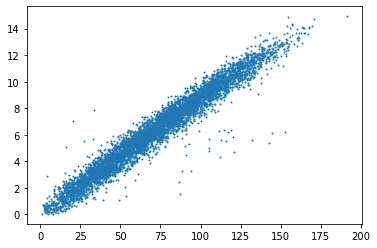

In [30]:
plt.scatter(random_real_distance, random_umap_distance, s= 1)

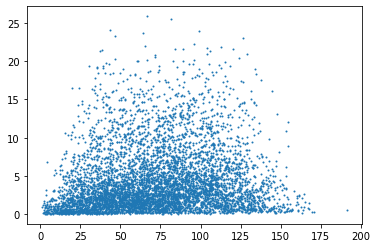

In [31]:
plt.scatter(random_real_distance, random_pca_distance, s= 1)

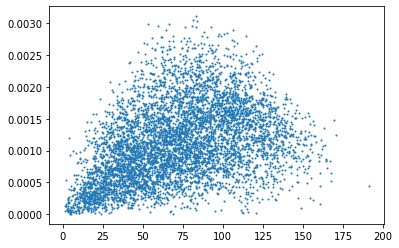

In [32]:
plt.scatter(random_real_distance, random_laplacian_distance, s= 1)

In [33]:
print(pearsonr(random_real_distance, random_umap_distance))
print(pearsonr(random_real_distance, random_pca_distance))
print(pearsonr(random_real_distance, random_laplacian_distance))

(0.9737241786938786, 0.0)
(0.13134687196570155, 1.691790374580088e-24)
(0.387818095523639, 1.4763907483051342e-214)


## Experimental script

In [109]:
def pca_function(randomZscore):

    # from sklearn.decomposition import PCA                                               # I don't have to import it here, unlike UMAP

    randomMousePCA = PCA()
    randomMousePCA.fit(randomZscore)

    randomPCA_scores = randomMousePCA.transform(randomZscore)                           # latent variables\ embedding

    return randomPCA_scores

In [110]:
def umap_function(randomZscore):
    
    import umap                                                                         # for some reason I have to import it in the function
    
    randomReducer = umap.UMAP()     # n_neighbors=
    randomUMAP_embedding = randomReducer.fit_transform(randomZscore)

    # print(randomUMAP_embedding.shape)

    return randomUMAP_embedding

In [111]:
def laplacian_function(randomZscore):

    # from sklearn.manifold import SpectralEmbedding                                      # I don't have to import it here, unlike UMAP

    randomLaplacian = SpectralEmbedding(n_components = 2)
    randomLaplacianEmbedding = randomLaplacian.fit_transform(randomZscore)

    return randomLaplacianEmbedding

## Start

In [115]:
results = []

n_cells = 50
# nSteps = 5000

minutes = 30
nSteps = minutes * 600

nLoops = 14
nLoops += 1

for i in range(1, nLoops):
    print("loop", i, "out of", nLoops, "initiated,", "number of cells:", n_cells)

    cellsList = generatePlaceCells(n_cells)

    (randomMouseData, randomMouseLocation) = randomMouse(cellsList, nSteps)
    randomZscore = np.nan_to_num(zscore(randomMouseData))
    print("data generated, randomZscore shape is " + str(randomZscore.shape) +", randomMouseLocation shape is " + str(randomMouseLocation.shape))

    pca = pca_function(randomZscore)
    print("PCA done")
    umap = umap_function(randomZscore)
    print("UMAP done")
    laplacian = laplacian_function(randomZscore)
    print("Laplacian done")



    
    n_cells += 20
    print()
    
    
print("FULLY DONE")
    

loop 1 out of 15 initiated, number of cells: 50
data generated, randomZscore shape is (18000, 50), randomMouseLocation shape is (2, 18000)
PCA done
UMAP done
Laplacian done

loop 2 out of 15 initiated, number of cells: 70
data generated, randomZscore shape is (18000, 70), randomMouseLocation shape is (2, 18000)
PCA done
UMAP done
Laplacian done

loop 3 out of 15 initiated, number of cells: 90
data generated, randomZscore shape is (18000, 90), randomMouseLocation shape is (2, 18000)
PCA done
UMAP done
Laplacian done

loop 4 out of 15 initiated, number of cells: 110
data generated, randomZscore shape is (18000, 110), randomMouseLocation shape is (2, 18000)
PCA done
UMAP done
Laplacian done

loop 5 out of 15 initiated, number of cells: 130
data generated, randomZscore shape is (18000, 130), randomMouseLocation shape is (2, 18000)
PCA done
UMAP done
Laplacian done

loop 6 out of 15 initiated, number of cells: 150
data generated, randomZscore shape is (18000, 150), randomMouseLocation shape